In [1]:
from io import BytesIO
from PIL import Image, ImageDraw, ImageFont
import base64
import diskcache
import os
import multiprocessing
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2

from ultralytics import YOLO, SAM
import torch
import pandas as pd
import numpy as np
np.seterr(over='ignore') # Ignore overflow errors

from dash import html, dcc, callback, long_callback
from dash.dependencies import Input, Output, State, ALL
from dash.long_callback import DiskcacheLongCallbackManager
import dash
import plotly.graph_objects as go
import webcolors
from plotly.subplots import make_subplots
import dash_bootstrap_components as dbc

### * Please asjust the images folder, results_csv_path and point locations before conduct the batch analysis



# Setup

In [2]:
### Important settings ###

img_dir = "sample_data/Camera1/TIMEL0001"

save_plots       = False  # Set to False to skip saving plots
save_annotations = False  # Set to False to skip saving annotations

results_dir      = "batch_results"

### Init models and image folder to analysis

In [8]:
# Folder paths

all_imgs = os.listdir(img_dir)

# Check number of images in the directory
print(f"Number of images in {img_dir}: {len(all_imgs)}")

# Get the parent folder name to use as the batch name
batch_name = os.path.basename(img_dir)

batch_results_dir = os.path.join(results_dir, batch_name)  # Creatxe batch-specific subfolder

os.makedirs(batch_results_dir, exist_ok=True)
# Update results_csv_path to be in the batch folder
results_csv_path = os.path.join(batch_results_dir, "results.csv")

# Create results directories if they don't exist
if save_plots or save_annotations:
    os.makedirs(batch_results_dir, exist_ok=True)
    
if save_plots:
    plots_dir = os.path.join(batch_results_dir, "plots")
    os.makedirs(plots_dir, exist_ok=True)
    
if save_annotations:
    annotations_dir = os.path.join(batch_results_dir, "annotations")
    os.makedirs(annotations_dir, exist_ok=True)

# Init models
object_detection_model = YOLO("models/yolo11x.pt")
sam2_segmentation_model = SAM("models/sam2.1_b.pt")
water_clearity_index_model = YOLO("models/WCI_cls_best.pt")


models = {
        'object_detection': object_detection_model,
        'segmentation': sam2_segmentation_model,
        'water_clearity_index': water_clearity_index_model,
        }

Number of images in sample_data/Camera1/TIMEL0001: 13


### Segmentation setup

For the segmentation, we need to provide a point location(s) of image for the AI model to predict the "object".

Using point location:
(1612, 907), (1344, 907), 

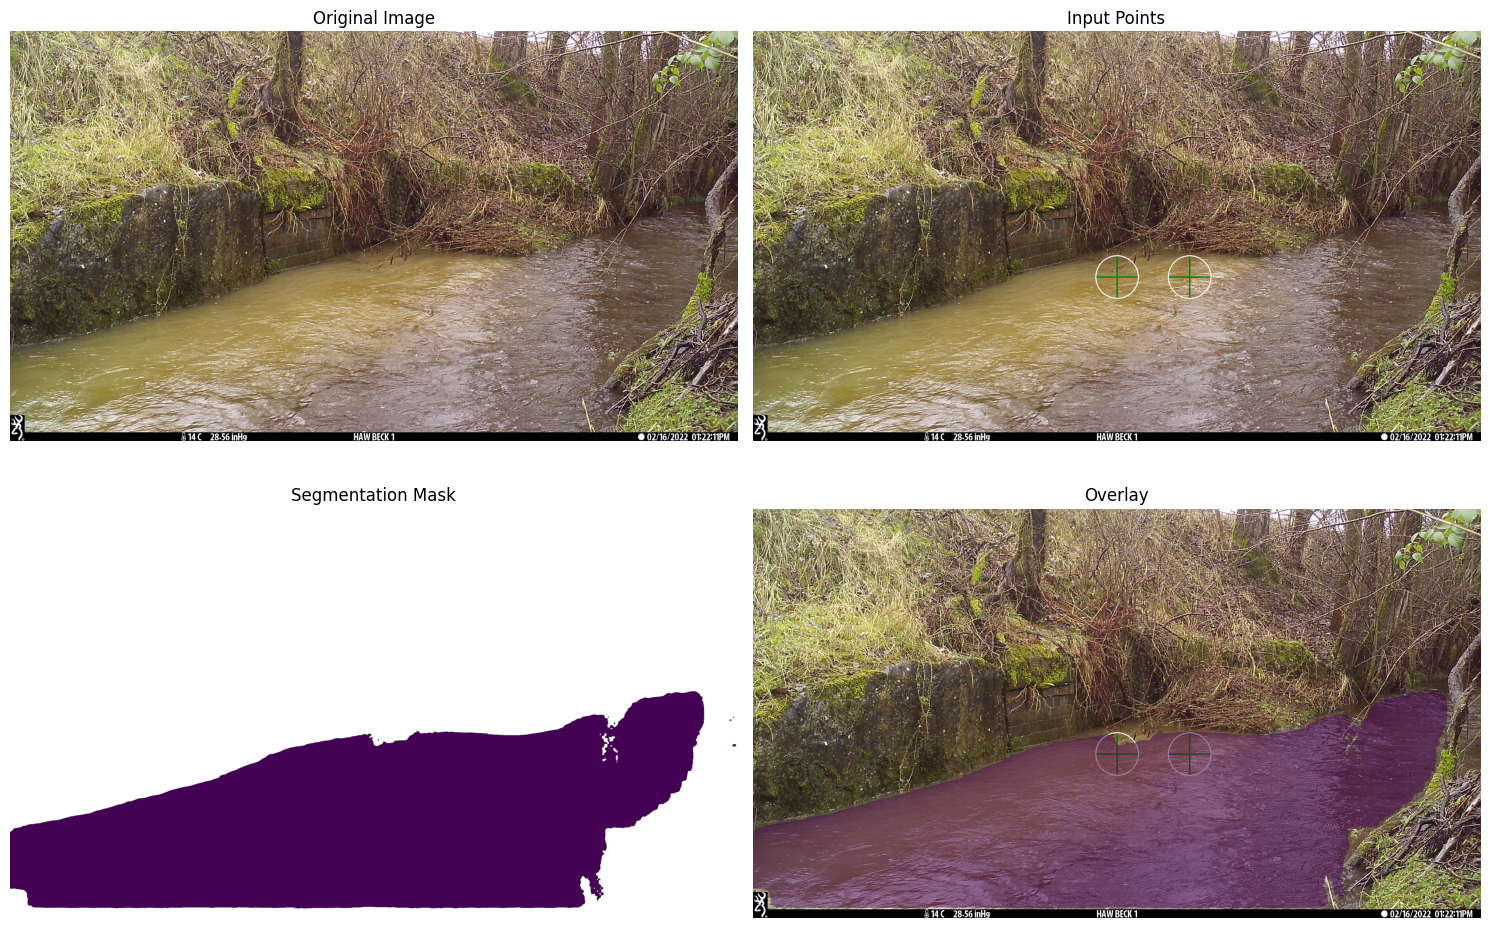

In [4]:

""" 
Please asjust the point location to get your desired object.
Range: 0 to 1 (Percentage of image size)
"""

point_x_percent = [0.6, 0.5, ]
point_y_percent = [0.6, 0.6, ]


########################################################################################

# Point location for segmentation
img_size = Image.open(os.path.join(img_dir, all_imgs[0])).size

point_x_pxs, point_y_pxs = [], []

print("Using point location:")
for x, y in zip(point_x_percent, point_y_percent):
    point_x_pxs.append(int(img_size[0] * x))
    point_y_pxs.append(int(img_size[1] * y))
    print(f"({int(img_size[0] * x)}, {int(img_size[1] * y)})", end=", ")

# # Plot the point on the image
img = Image.open(os.path.join(img_dir, all_imgs[0]))
img_draw = img.copy()
draw = ImageDraw.Draw(img_draw)

# 1% of the image size
marker_size = int(img.size[0] * 0.03)

for point_x_px, point_y_px in zip(point_x_pxs, point_y_pxs):
    # Draw a cross marker with white outline
    draw.line((point_x_px - marker_size, point_y_px, point_x_px + marker_size, point_y_px), 
                fill='green', width=5)
    draw.line((point_x_px, point_y_px - marker_size, point_x_px, point_y_px + marker_size), 
                fill='green', width=5)
    
    # Draw a circle around the cross
    draw.ellipse((point_x_px - marker_size, point_y_px - marker_size, 
                    point_x_px + marker_size, point_y_px + marker_size), 
                outline='white', width=4)

# Preview the segmentation results
results = sam2_segmentation_model.predict(
        img,
        points=[[point_x_px, point_y_px]],
        verbose=False
        )

single_mask = results[0].masks.data.cpu().numpy()[0].astype(float)
single_mask[single_mask == 0] = np.nan

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes = axes.flatten()

for ax in axes:
    ax.axis('off')

axes[0].set_title('Original Image')
axes[1].set_title('Input Points')
axes[2].set_title('Segmentation Mask')
axes[3].set_title('Overlay')

axes[0].imshow(img)
axes[1].imshow(img_draw)
axes[2].imshow(single_mask)
axes[3].imshow(img_draw)
axes[3].imshow(single_mask, alpha=0.5)

plt.tight_layout()
plt.show()

## Confindence setting for the object detection

In [5]:
obj_dect_conf = 0.6

## Help functions

In [6]:
# Function to get the closest colour name
def closest_colour(requested_colour):
    min_colours = {}
    for name in webcolors.names("css3"):
        r_c, g_c, b_c = webcolors.name_to_rgb(name)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]


# Function to get the actual colour name
def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return actual_name, closest_name


# Batch process

In [9]:
all_results_df = []

for image in tqdm(all_imgs):

    img = Image.open(os.path.join(img_dir, image))
    
    ### Object Detection
    od_result = models['object_detection'].predict(
        img,
        conf=obj_dect_conf,
        verbose=False
    )
    detected_classes = [models['object_detection'].names[cls] for cls in od_result[0].boxes.cls.cpu().tolist()]
    detected_conf    = od_result[0].boxes.conf.cpu().tolist()
    detection_count  = len(od_result[0].boxes.cls)

    if detection_count == 0:
        detected_classes = 0
        detected_conf = 0

    #########################################################
    
    ### Segmentation
    seg_result = models['segmentation'].predict(
        img,
        points=[[point_x_px, point_y_px]],
        verbose=False
    )

    idx_with_biggest_area = np.argmax(seg_result[0].masks.data.cpu().numpy().sum(axis=(1, 2)))
    single_mask = seg_result[0].masks.data.cpu().numpy()[idx_with_biggest_area]
    segmentation_area = float(single_mask.sum())
    
    #########################################################
    
    ### Water Clarity Index
    wci_result = models['water_clearity_index'].predict(img, verbose=False)
    probs = wci_result[0].probs.data.cpu().numpy()
    overall_score = 1 * probs[0] + 0.5 * probs[1] + 0.0 * probs[2]
    overall_color = np.mean(wci_result[0].orig_img, axis=(0, 1)).astype(np.uint8)
    _, closest_name = get_colour_name(overall_color)
    
    # Create a dataframe for the current image
    single_df = pd.DataFrame({
        'image_name': image,
        'OD_detection_count': detection_count,
        'OD_detected_classes': detected_classes,
        'OD_detected_confidences': detected_conf,
        'segmentation_area': segmentation_area,
        'WCI_score': float(overall_score),
        'WCI_color': closest_name
    },
    index=[0])
    all_results_df.append(single_df)

    if save_plots:
        # Create visualization figure
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
        
        for ax in axes:
            ax.axis('off')
            
        axes[0].set_title('Original Image')
        axes[1].set_title('Object Detection')
        axes[2].set_title('Segmentation Mask')
        axes[3].set_title('Water Clarity')
        
        # Plot original
        axes[0].imshow(img)
        
        # Plot object detection - convert tensor to numpy array
        od_plot = od_result[0].plot()
        if isinstance(od_plot, torch.Tensor):
            od_plot = od_plot.cpu().numpy()
        # Ensure correct color channel order (BGR to RGB if needed)
        if od_plot.ndim == 3 and od_plot.shape[2] == 3:
            od_plot = cv2.cvtColor(od_plot, cv2.COLOR_BGR2RGB)
        axes[1].imshow(od_plot)
        
        # Plot segmentation
        axes[2].imshow(img)
        axes[2].imshow(single_mask, alpha=0.5)
        
        axes[3].imshow(img)
        axes[3].text(10, 30, f'WCI Score: {overall_score:.2f}', 
                    color='white', fontsize=12, 
                    bbox=dict(facecolor='black', alpha=0.7))
        
        plt.tight_layout()
        plot_path = os.path.join(plots_dir, f"{os.path.splitext(image)[0]}_analysis.png")
        plt.savefig(plot_path, bbox_inches='tight', dpi=300)
        plt.close()
    
    if save_annotations:
        # Save annotations in JSON format
        annotation_data = {
            'image_name': image,
            'object_detection': {
                'classes': detected_classes,
                'confidences': detected_conf,
                'count': detection_count
            },
            'segmentation': {
                'area': float(segmentation_area),
                'mask_shape': single_mask.shape,
                'points_used': list(zip(point_x_pxs, point_y_pxs))
            },
            'water_clarity': {
                'score': float(overall_score),
                'color': closest_name
            }
        }
        
        import json
        annotation_path = os.path.join(annotations_dir, f"{os.path.splitext(image)[0]}_annotation.json")
        with open(annotation_path, 'w') as f:
            json.dump(annotation_data, f, indent=4)

all_results_df = pd.concat(all_results_df, ignore_index=True)
# Save with 2 decimal places
# results_csv_path is defined at "Setup" section
all_results_df.to_csv(results_csv_path, index=False, float_format="%.2f")

# After the loop, add a summary of saved files
if save_plots or save_annotations:
    print("\nResults saved:")
    if save_plots:
        print(f"- Plots saved to: {plots_dir}")
    if save_annotations:
        print(f"- Annotations saved to: {annotations_dir}")
print(f"- Results CSV saved to: {results_csv_path}")

100%|██████████| 13/13 [00:03<00:00,  4.09it/s]

- Results CSV saved to: batch_results/TIMEL0001/results.csv
